In [ ]:
import torch
import torch.nn as nn
from numpy import random

In [ ]:
IMG_SIZE = 32
EMB_DIM = 768
N_HEADS = 1
N_LAYERS = 4
N_CLASSES = 100
PATCH_SIZE = 16
DROPOUT = 0.1
LR = 1e-5

#Multihead Self Attention

In [ ]:
class Attention(nn.Module):
    """
    parameters: 
        + dim: int
            dimension of input
        + n_heads: int
            number of head in multihead attention
        + dropout: float
            dropout probability

    attribute:
        + self.qkv: Linear(dim, 3*dim)
        + self.scale: float:
        + self.head_dim: int
        + self.proj: Linear(dim, dim)
    """

    def __init__(self, dim = EMB_DIM, n_heads = N_HEADS, dropout = DROPOUT):
        super().__init__()
        self.dim = dim 
        self.n_heads = n_heads
        self.head_dim = dim // n_heads 
        self.scale = (self.head_dim) ** (-0.5)
        self.qkv = nn.Linear(dim, dim*3)
        self.proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        input: 
            + x: torch.Tensor:
                shape = (batch x (N+1) x dim)
        returns:
            + torch.Tensor:
                shape = (batch x (N+1) x dim)        
        """
        batch, N, dim = x.shape
        N = N-1

        qkv = self.qkv(x)
        #batch x (N+1) x 3.dim
        qkv = qkv.reshape(
            batch, N+1, 3, self.n_heads, self.head_dim
        )
        #(batch x (N+1) x 3 x n_heads x head_dim)
        qkv = qkv.permute(
            2,0,3,1,4
        )
        #(3 x batch x n_heads x (N+1) x head_dim)


        q = qkv[0] #(batch x n_heads x (N+1) x head_dim)
        k = qkv[1] #(batch x n_heads x (N+1) x head_dim)
        v = qkv[2] #(batch x n_heads x (N+1) x head_dim)

        attn_weight = (q @ k.transpose(-2,-1))*self.scale
        #(batch x n_heads x (N+1) x (N+1))
        attn_weight = attn_weight.softmax(dim = -1)
        attn_weight = self.dropout(attn_weight)

        attn_score = attn_weight @ v
        #(batch x n_heads x (N+1) x head_dim)
        attn_score = attn_score.transpose(1,2)
        attn_score = attn_score.flatten(-2)
        #(batch x n_heads x dim)
        out = self.proj(attn_score)

        return out


In [ ]:
x = torch.rand(256, 4, 768)
x.shape

torch.Size([256, 4, 768])

In [ ]:
test_attention = Attention()

In [ ]:
test_attention = Attention()
out = test_attention(x)
out.shape

torch.Size([256, 4, 768])

# MLP

In [ ]:
class MLP(nn.Module):
    """
    parameters:
        + in_dim: int
        + hidden_dim: int 
        + out_dim: int
        + dropout
    attribute:
        + self.fc1 = nn.Linear(in_dim, hidden_dim)
        + self.fc2 = nn.Linear(hidden_dim, out_dim)
        + self.dropout = nn.Dropout(dropout)
        + self.act: nn.GLEU()
            activate function
    """
    def __init__(self, in_dim = EMB_DIM, hidden_dim = 1024, out_dim = EMB_DIM, dropout = DROPOUT):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hidden_dim = hidden_dim

        self.dropout = nn.Dropout(dropout)
        self.fc1= nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.act = nn.GELU()

    def forward(self, x):
        """
        input: 
            + x: torch.Tensor
                shape = (batch x (N+1) x dim)
        returns:
            torch.Tensor:
                shape = (batch x (N+1) x dim)
        """

        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

In [ ]:
test_MLP = MLP()

In [ ]:
y = test_MLP(x)

In [ ]:
y.shape

torch.Size([256, 4, 768])

# Build block

In [ ]:
class Block(nn.Module):
    """
    parameters:
        + dim: int
        + n_heads: int
        + hidden_dim: int
        + dropout: float
    attribute:
        + self.mlp
        + self.norm1, self.norm2: LayerNorm
        + self.attn
    """

    def __init__(self, dim = EMB_DIM , n_heads = N_HEADS, hidden_dim = 1024, dropout = DROPOUT):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps = 1e-6)
        self.norm2 = nn.LayerNorm(dim, eps = 1e-6)
        self.mlp = MLP(
            in_dim = dim,
            hidden_dim = hidden_dim,
            out_dim = dim,
            dropout = dropout
        )

        self.attn = Attention(
            dim = dim, 
            n_heads = n_heads, 
            dropout = dropout
        )
    def forward(self, x):
        """
        input: 
            + x: torcch.Tensor:
                shape = (batch x (N+1) x dim)
        return:
            torch.Tensor:
                shape = (batch x (N+1) x dim)
        """
        x = self.attn(self.norm1(x)) + x
        x = self.mlp(self.norm2(x)) + x
        return x

In [ ]:
test_block = Block()

In [ ]:
y = test_block(x)

In [ ]:
y.shape

torch.Size([256, 4, 768])

# Data


## DataLoader

In [ ]:
import torchvision
import torchvision.transforms as transforms

Using cifar-100 dataset.

Convert to list for more convenient use: 
ref: https://stackoverflow.com/questions/62208904/pytorch-custom-dataset-dataloader-returns-a-list-of-tensors-rather-than-tensor

In [ ]:
class Custom_Dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, _dataset):
        self.dataset = _dataset

    def __getitem__(self, index):
        example, target = self.dataset[index]
        return example, target

    def __len__(self):
        return len(self.dataset)

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256
trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform = transform)
trainloader = torch.utils.data.DataLoader(Custom_Dataset(trainset), batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform = transform)
validloader = torch.utils.data.DataLoader(Custom_Dataset(testset), batch_size=batch_size,
                                         shuffle=False, num_workers=2)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
for image, label in trainloader:
    print(image.shape)
    print(label)
    print(label.shape)
    break

torch.Size([256, 3, 32, 32])
tensor([34,  4, 29,  1, 39, 19, 61, 75, 85, 96, 52, 63, 69,  9, 57, 84, 84, 84,
        15,  1, 84, 84, 21, 21, 50, 72, 95, 23, 90, 73, 97, 43, 50, 43, 82, 89,
        72,  1, 58, 33, 37, 95, 74, 21,  3, 88, 59,  7, 38, 88, 49, 71, 74, 99,
        42,  5, 58, 88, 18, 43, 98, 50, 23, 47, 73,  1, 59, 57, 60, 36, 69, 48,
        50, 85, 88, 83, 42, 53,  8, 88, 95, 72, 85, 29, 35, 81, 20, 54, 96, 54,
        40, 85, 37, 94, 56, 61, 95,  1,  3,  5, 27, 24, 48, 78, 29, 82, 45, 56,
        64, 87, 75, 54, 53, 33, 94, 90, 99, 49,  0, 89,  1, 98,  1, 19, 21, 63,
        78, 40, 60, 72, 76, 81, 75,  9, 11, 54, 56, 78, 67, 27, 16, 16,  4, 91,
        36, 40, 35, 59, 94, 98, 67, 51, 20, 23, 50, 79, 47, 86, 43, 98, 54, 36,
        80, 64, 37, 63, 13, 79, 95,  1,  2, 99, 27, 80, 86,  7, 70, 48, 98,  4,
        37, 88,  6, 23, 51, 41, 39, 33, 44, 61, 43,  6, 17, 67, 65, 28, 40, 22,
        52, 55, 47, 45, 73, 84, 17, 16, 86, 32, 50,  7, 30, 42, 47, 48, 33, 75,
        12,

## Patches

* Input: 1 batch image: `batch = 256`, shape = `[3,32,32] = [channel, height_size, width_size]`

* For each image, cut to patch with size, `patch_size = 16`
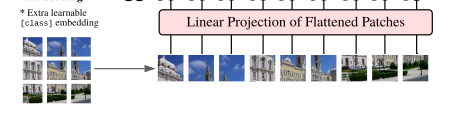



* Patches: `n_patches` = $(\frac{\text{imgSize}}{\text{patchSize}})^2$
* Output: [batch, n_paches, emb_dim]

In [ ]:
!pip install einops
from einops import rearrange

In [ ]:
class Patch(nn.Module):
    """"
    params:
        + img_size: int
        + emb_dimm: int 
        + patch_size: int
        + channel: int
    attribute:
        + patch_dim: channel * patch_size ^2 
        + n_paches: (img_size//patch_size) ** 2 
        + patch_to_embedding: nn.Linear(patch_dim, emb_dim)
            shape = [batch, n_patches, emb_dim]
    """
    def __init__(self, img_size = IMG_SIZE, emb_dim = EMB_DIM, patch_size = PATCH_SIZE, channel = 3):
        super().__init__()
        self.img_size = img_size
        self.emb_dim = emb_dim 
        self.patch_size = patch_size
        self.n_patches = (img_size//patch_size)**2
        self.patch_dim = channel * self.patch_size ** 2
        self.patch_to_embedding = nn.Linear(self.patch_dim, emb_dim)
    
    def forward(self,x):
        """"
        input:
            + x: torch.Tensor:
                shape = [batch, channel, img_size, img_size]
        return:
            + torch.Tensor():
                shape = [batch, n_patches, emb_dim]
        """
        x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = self.patch_size, p2 = self.patch_size)
        x = self.patch_to_embedding(x)

        return x



In [ ]:
x = torch.Tensor(random.rand(256,3,32,32))
x.shape

torch.Size([256, 3, 32, 32])

In [ ]:
test_patch = Patch()
y = test_patch(x)
y.shape

torch.Size([256, 4, 768])

# ViT

In [ ]:
class ViT(nn.Module):
    def __init__(
        self,
        img_size = IMG_SIZE, 
        patch_size = PATCH_SIZE, 
        dim = EMB_DIM,
        n_heads = N_HEADS,
        n_layers = N_LAYERS, 
        hidden_dim_mlp = 1024, 
        n_classes = N_CLASSES,
        dropout = DROPOUT
        ):

        super().__init__()
        self.img_emb = Patch(img_size,dim, patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1,1,dim))
        self.pos_emb = nn.Parameter(torch.zeros(1,self.img_emb.n_patches + 1, dim))
        self.dim = dim 
        self.blocks = nn.ModuleList(
            [
                Block(dim, n_heads, hidden_dim=hidden_dim_mlp, dropout = dropout) 
                for _ in range(n_layers)
            ]

        )
        self.out = nn.Linear(dim, n_classes)
    def forward(self,x):
        """
        imput:
            x: (IMG) torch.Tensor
                shape = [batch, channel, img_size, img_size]
        return torch.Tensor()
        """
        batch = x.shape[0]
        x = self.img_emb(x)
        #batch x n_patchese x dim
        cls_token = self.cls_token.expand(
            batch, -1, -1 
        )
        # print('cls init shape : ', cls_token.shape)
        # batch x 1 x dim
        x = torch.cat((cls_token, x), dim = 1)
        #batch x (n_patches + 1) x dim 
        x = x + self.pos_emb

        for block in self.blocks:
            x = block(x)

        # print(x.shape)
        cls_token = x[:,0]
        # print('cls_token shape : ', cls_token.shape)
        out = self.out(cls_token)
        # print(f'out shape =  {out.shape}')
        return out

Note: torch.expand, if dimension not changing, passing -1. 
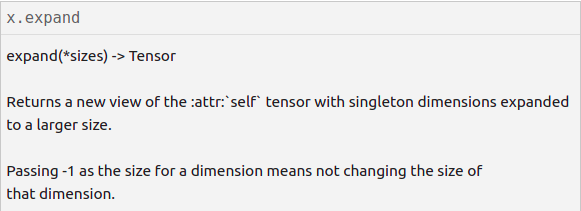

In [ ]:
x = torch.Tensor(random.rand(256, 3, 32,32))

In [ ]:
test_Vit = ViT()
y = test_Vit(x)
y.shape

torch.Size([256, 100])

# Training

In [ ]:
!pip install wandb

In [ ]:
import wandb
import torch.optim as optim
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
model = ViT().to(device)
optimizer = optim.Adam(params= model.parameters(), lr = LR, weight_decay=0.1)
criterion = nn.CrossEntropyLoss()
EPOCHS = 400


In [ ]:
def eval(model, loader):
  model.eval()
  loss = []
  acc = []
  with torch.no_grad():
    for x, y in loader:
      y_pred = model(x.to(device))
      l = criterion(y_pred, y.to(device))
      a = accuracy_score(y.cpu(), y_pred.cpu().argmax(dim=1))
      loss.append(l.item())
      acc.append(a.item())
  return sum(loss)/len(loss), sum(acc)/len(acc)

In [ ]:
def train(model, train_loader, val_loader):
  wandb.init(project="vision-transformer")
  STEPS = 0
  for EPOCH in tqdm(range(EPOCHS)):
    loss = []
    acc = []
    for x, y in train_loader:
      x = x.to(device)
      y = y.to(device)
      y_pred = model(x)
      
      # compute the loss and backpropagate
      l = criterion(y_pred, y)
      optimizer.zero_grad()
      l.backward()
      optimizer.step()

      a = accuracy_score(y.cpu(), y_pred.cpu().argmax(dim=1))
      wandb.log({"Step Training Accuracy": a.item(), "Step Training Loss": l.item()})
      
      loss.append(l.item())
      acc.append(a.item())
      STEPS += 1

    avg_loss = sum(loss)/len(loss)
    avg_acc = sum(acc)/len(acc)
    val_loss, val_acc = eval(model, val_loader)
    wandb.log({"Training Accuracy": avg_acc, "Training Loss": avg_loss, "Validation Accuracy":val_acc, "Validation Loss":val_loss})
    print(f"EPOCH :{EPOCH}/{EPOCHS} | Train_acc: {avg_acc:.4f} | Train_loss: {avg_loss:.4f} | Val_loss: {val_loss:.4f} | Val_acc: {val_acc:.4f}")

In [ ]:
train(model = model,train_loader= trainloader,val_loader= validloader)

 51%|█████▏    | 205/400 [47:09<44:38, 13.74s/it]

EPOCH :204/400 | Train_acc: 0.1147 | Train_loss: 3.7115 | Val_loss: 3.9027 | Val_acc: 0.0954


 51%|█████▏    | 205/400 [47:13<44:54, 13.82s/it]


KeyboardInterrupt: ignored

In [ ]:
# saving model checkpoint
torch.save(model.state_dict(), 'weight.pt')

In [ ]:
# load model checkpoint
checkpoint = torch.load('weight.pt')
model.load_state_dict(checkpoint)

# Evaluation

### Class name mapping

In [ ]:
coarse_label = [
'apple', # id 0
'aquarium_fish',
'baby',
'bear',
'beaver',
'bed',
'bee',
'beetle',
'bicycle',
'bottle',
'bowl',
'boy',
'bridge',
'bus',
'butterfly',
'camel',
'can',
'castle',
'caterpillar',
'cattle',
'chair',
'chimpanzee',
'clock',
'cloud',
'cockroach',
'couch',
'crab',
'crocodile',
'cup',
'dinosaur',
'dolphin',
'elephant',
'flatfish',
'forest',
'fox',
'girl',
'hamster',
'house',
'kangaroo',
'computer_keyboard',
'lamp',
'lawn_mower',
'leopard',
'lion',
'lizard',
'lobster',
'man',
'maple_tree',
'motorcycle',
'mountain',
'mouse',
'mushroom',
'oak_tree',
'orange',
'orchid',
'otter',
'palm_tree',
'pear',
'pickup_truck',
'pine_tree',
'plain',
'plate',
'poppy',
'porcupine',
'possum',
'rabbit',
'raccoon',
'ray',
'road',
'rocket',
'rose',
'sea',
'seal',
'shark',
'shrew',
'skunk',
'skyscraper',
'snail',
'snake',
'spider',
'squirrel',
'streetcar',
'sunflower',
'sweet_pepper',
'table',
'tank',
'telephone',
'television',
'tiger',
'tractor',
'train',
'trout',
'tulip',
'turtle',
'wardrobe',
'whale',
'willow_tree',
'wolf',
'woman',
'worm',
]

## Helper function

In [ ]:
import os
import cv2
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def table_image_plot(img_list, preds, max_col=3):
  ax = []
  cols = max_col
  rows = len(img_list)//cols

  fig = plt.figure()
  for i in range(len(img_list)):
    img = img_list[i].detach().numpy()
    img = np.moveaxis(img, 0, -1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.append(fig.add_subplot(rows, cols, i+1))
    ax[-1].set_title(f"class: {coarse_label[preds[i]]}")
    plt.imshow(img)
  plt.show()

## Load image from folder: `test`

In [ ]:
!unzip test.zip

Archive:  test.zip
  inflating: test/apples.jpg         
  inflating: test/cloud.jpg          
  inflating: test/mountain.jpg       


In [ ]:
model.eval()
test_list = os.listdir('./test')
img_list = []

p = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
for test_sample in test_list:
  img = cv2.imread(os.path.join('./test', test_sample))
  img_list.append(p(img))

imgs = torch.stack(img_list).cuda()
print(imgs.shape)
preds = model(imgs)
print(preds.shape)

torch.Size([3, 3, 32, 32])
torch.Size([3, 100])


In [ ]:
# get the maxium prediction of each image
preds = preds.cpu().argmax(dim=1)
print(preds)

tensor([23, 61, 61])


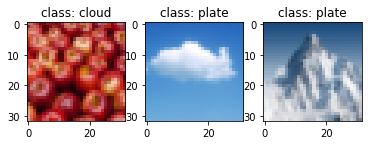

In [ ]:
table_image_plot(img_list, preds)